# Exploratory Data Analysis (EDA)

## Fit.ly Customer Churn Analysis


The objective of this notebook is to validate data quality, understand the structure of the available datasets, 
and identify key patterns and limitations relevant to customer churn analysis. 

This step focuses on data validation and exploratory understanding rather than modeling or prediction.


In [25]:
# Libraries:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

In [26]:
# Ingest Raw data:

account_info = pd.read_csv("../data/raw/da_fitly_account_info.csv")
customer_support = pd.read_csv("../data/raw/da_fitly_customer_support.csv")
user_activity = pd.read_csv("../data/raw/da_fitly_user_activity.csv")

In [27]:
# structural overview:

datasets = {
    "Account Info": account_info,
    "Customer Support": customer_support,
    "User Activity": user_activity
}

for name, df in datasets.items():
    print(f"\n{name}")
    print("-" * len(name))
    print("Shape:", df.shape)
    display(df.head())
    
    df.info()


Account Info
------------
Shape: (400, 6)


,customer_id,email,state,plan,plan_list_price,churn_status
0,C10000,user10000@example.com,New Jersey,Enterprise,105,Y
1,C10001,user10001@example.net,Louisiana,Basic,22,Y
2,C10002,user10002@example.net,Oklahoma,Basic,24,NaN
3,C10003,user10003@example.com,Michigan,Free,0,NaN
4,C10004,user10004@example.com,Texas,Enterprise,119,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   customer_id      400 non-null    object
 1   email            400 non-null    object
 2   state            400 non-null    object
 3   plan             400 non-null    object
 4   plan_list_price  400 non-null    int64 
 5   churn_status     114 non-null    object
dtypes: int64(1), object(5)
memory usage: 18.9+ KB

Customer Support
----------------
Shape: (918, 7)


,ticket_time,user_id,channel,topic,resolution_time_hours,state,comments
0,2025-06-13 05:55:17.154573,10125,chat,technical,11.48,1,NaN
1,2025-08-06 13:21:54.539551,10109,chat,account,1.01,0,NaN
2,2025-08-22 12:39:35.718663,10149,chat,technical,10.09,0,Erase my data from your systems.
3,2025-06-07 02:49:46.986055,10268,phone,account,9.10,1,NaN
4,2025-07-25 00:24:38.945079,10041,phone,other,2.28,1,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ticket_time            918 non-null    object 
 1   user_id                918 non-null    int64  
 2   channel                918 non-null    object 
 3   topic                  918 non-null    object 
 4   resolution_time_hours  918 non-null    float64
 5   state                  918 non-null    int64  
 6   comments               46 non-null     object 
dtypes: float64(1), int64(2), object(4)
memory usage: 50.3+ KB

User Activity
-------------
Shape: (445, 3)


,event_time,user_id,event_type
0,2025-09-08 15:05:39.422721,10118,watch_video
1,2025-09-08 08:15:05.264103,10220,watch_video
2,2025-11-14 06:28:35.207671,10009,share_workout
3,2025-08-20 16:53:38.682901,10227,read_article
4,2025-07-24 16:47:31.728422,10123,track_workout


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445 entries, 0 to 444
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event_time  445 non-null    object
 1   user_id     445 non-null    int64 
 2   event_type  445 non-null    object
dtypes: int64(1), object(2)
memory usage: 10.6+ KB


---
### Dataset 1: Account Information (account_info)

This dataset represents the customer master table and serves as the primary source of:
- Customer attributes
- Subscription plan information
- Churn labels (when available)

Structure:
- Rows: 400 customers
- Columns: 6
- One row per customer

Key fields:
- customer_id: primary customer identifier
- plan, plan_list_price: monetization indicators
- state: geographic segmentation
- churn_status: churn indicator (Y / missing)
- Data quality observations

All customer attributes and pricing fields are complete.
The churn_status field is populated for 114 out of 400 customers (~28.5%).
- The remaining customers have missing churn labels.
- Validation insight (critical)
- The partial availability of churn labels implies:
- Churn data is incomplete, not negative.
- Customers without labels cannot be assumed to be retained.
- Analysis will focus on patterns associated with churn, not precise churn rate estimation.

This limitation is explicitly acknowledged and accounted for in downstream analysis.

---
### Dataset 2: Customer Support (customer_support)

This dataset captures customer friction and service interactions, used to evaluate:
- Whether higher support usage correlates with churn
- Whether longer resolution times indicate churn risk

Structure:
- Rows: 918 support tickets
- Columns: 7
- Multiple records per customer

Key fields:
- user_id: customer identifier (to be joined with customer_id)
- channel: support channel used
- topic: issue category
- resolution_time_hours: proxy for service quality
- state: numeric indicator (interpreted as ticket status)
- comments: free-text field

Data quality observations:
- All operational fields are complete.
- comments is populated for only 46 records (~5%)

Validation decisions:
- comments will be excluded from quantitative analysis due to high sparsity.
- state is treated as a ticket status indicator, not geographic data.
- Aggregation is required at the customer level (e.g., ticket count, average resolution time).

---
### Dataset 3: User Activity (user_activity)
This dataset represents user engagement behavior, which is central to churn analysis.

Structure:
- Rows: 445 activity events
- Columns: 3
- Multiple events per user

Key fields:
- user_id: customer identifier
- event_time: timestamp of activity
- event_type: type of engagement action

Supported engagement actions:
- track_workout
- watch_video
- read_article
- share_workout

Validation insight:
- Activity data enables:
    - Engagement volume per customer
    - Engagement mix by action type
- Temporal features (recency, frequency) may be derived if needed.

## Metrics & Aggregation:

### Account Information Overview:

This examines the customer master table, including plan distribution,
pricing, geographic spread, and availability of churn labels.


In [28]:
# account_info overview:

print(account_info.shape)
account_info.info()
account_info.head()

# obviously churn_status column is the only one that has more nan values

(400, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   customer_id      400 non-null    object
 1   email            400 non-null    object
 2   state            400 non-null    object
 3   plan             400 non-null    object
 4   plan_list_price  400 non-null    int64 
 5   churn_status     114 non-null    object
dtypes: int64(1), object(5)
memory usage: 18.9+ KB


,customer_id,email,state,plan,plan_list_price,churn_status
0,C10000,user10000@example.com,New Jersey,Enterprise,105,Y
1,C10001,user10001@example.net,Louisiana,Basic,22,Y
2,C10002,user10002@example.net,Oklahoma,Basic,24,NaN
3,C10003,user10003@example.com,Michigan,Free,0,NaN
4,C10004,user10004@example.com,Texas,Enterprise,119,NaN


In [29]:
# Churn label availability:

account_info["churn_status"].value_counts(dropna=False)

# confirms that Nan there are quite a lot Nan Values in this column

churn_status
NaN    286
Y      114
Name: count, dtype: int64

In [30]:
# Percentage of customers with churn label:

account_info["churn_status"].notna().mean() * 100

# we got like 28.5% mean
# this mean only 28% of customers have churned or have churn labels
# i think this hsould focus on patterns not predictions

np.float64(28.499999999999996)

#### Plan & Pricing Distribution:

In [31]:
# Plan distribution:

account_info["plan"].value_counts()

# shows there are 4 categories under the plan column and basic is the most while pro is least which was expected

plan
Basic         118
Free          105
Enterprise     92
Pro            85
Name: count, dtype: int64

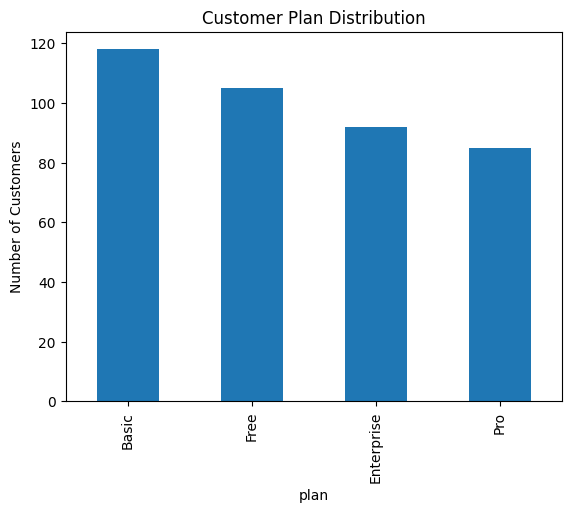

In [32]:
# customer base composition

account_info["plan"].value_counts().plot(kind="bar")
plt.title("Customer Plan Distribution")
plt.ylabel("Number of Customers")
plt.show()

In [33]:
# Price summary by plan:

account_info.groupby("plan")["plan_list_price"].describe()

# free plan is 0 in all levels, tis confirms this group has no activity or cost
# Enterprice: has the most variation, this group has different usage levels 
#       - this is relatively balance with mean 116 and median of 119 with a sligt left skewed
# pro: is the lowest of all groups with count of /5 in total with an avg of 53.74 mean and median are quite identical
#       - very symmetric or normal distribution
# basic: is with the highest number of users wiith an avg of 19.9% and a median of 20 
#       - this suggest an almost symmetric distribution with a very slight skew to the righ
#       - this also has the lowest stddev amongst all groups, this means that users under this are mostly consistent and predictable
# the way it looks there is no overlap between groups if you look into the min & max values
# - this means they are stricly capped and segmented by values themselves
# - meaning there is a clean gap or segmentation between groups, they are perfectly separated accordnly

,count,mean,std,min,25%,50%,75%,max
plan,,,,,,,,
Basic,118.0,19.872881,5.914702,10.0,15.0,20.0,24.0,30.0
Enterprise,92.0,116.010870,20.532737,81.0,96.5,119.0,134.0,148.0
Free,105.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Pro,85.0,53.741176,14.595460,32.0,42.0,53.0,64.0,80.0


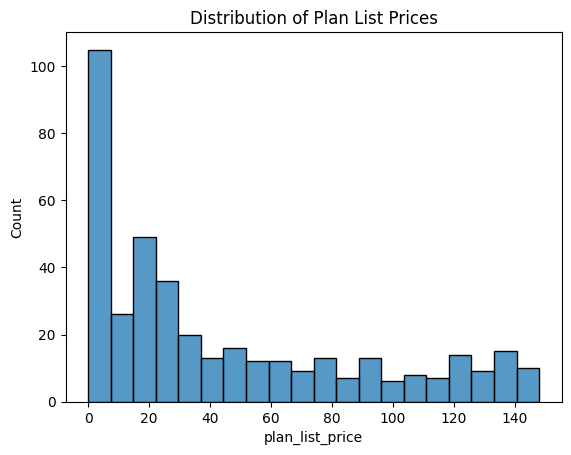

In [34]:
# Price distribution
plt.figure()
sns.histplot(account_info["plan_list_price"], bins=20)
plt.title("Distribution of Plan List Prices")
plt.show()

# the majority or the hump of the data point are clustered on the leftside of the graph these are mostlikely free tier accounts
# the graph shows free tier accounts dominate this histogram the most, spcificalt at the lower end of the dataset (bins: 0-10 & 10-20)
# while accounts with basic tiers follows suit as the graph drasticaly flows positively skewed distribution
# positively skewd (or right skewed) distribution means we have a longer tail that extends in the positive direction (right)
# mosly because of the measures of tendenct is mode < median < mean - the mean is pulled yop the right by extreme values

### Customer Support Overview:

analyzes support usage as a proxy for customer friction,
including ticket volume, channel usage, and resolution times.

In [35]:
# Tickets per user

tickets_per_user = customer_support.groupby("user_id").size()
tickets_per_user.describe()

# total number of unique users with at least 1 ticket created is 367 
# mean is 2.5 while median is 2.0 a bit right skewed data with mean > the median
# std is 1.3, which is tipical or avg variation, meaning were 1.3 ticjets away from the mean of 2.5
# the smallest value is 1 while th largest is 8 with a range of 7 and majority of these values fall on 3 tickets
# - meaning 75% of users made 3 and the rest is fewer
# values are capped at 8, as the said value is the maximum value observed in the data.

count    367.000000
mean       2.501362
std        1.305463
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        8.000000
dtype: float64

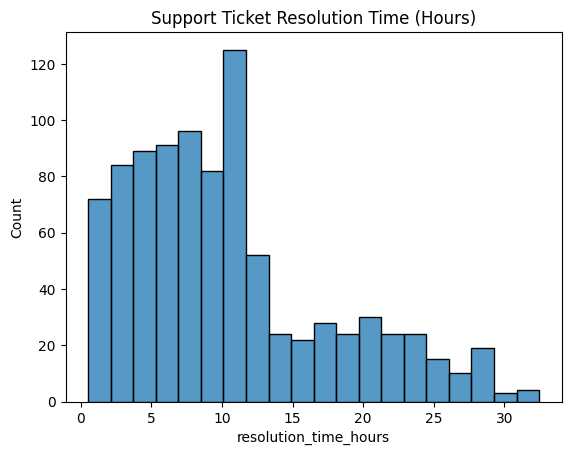

In [36]:
# Resolution time distribution

plt.figure()
sns.histplot(customer_support["resolution_time_hours"], bins=20)
plt.title("Support Ticket Resolution Time (Hours)")
plt.show()

# this graph explicitly plots the count of support tickets against their resolution time in hours (shape of the distribution)
# - how long it took for a call to be resolved 
# The highest concentration of tickets occurs around the 10–12 hour range with approx 130 calls in total
# The longest resolution time is arround 30hrs
# - The count for this final bin appears to be exactly 5
# - this bin also represent one of the least frequent types of calls with the bin around the 28-hour mark
# the graph shows that the distribution itself is right skewd
# - this means most calls are resolved relatively quicker under 15hrs
# There is evidence of clustering at higher resolution times, though the distribution is primarily right-skewed
# - this graph also appears to be bimodal while the primary peaks at 10-12hrs the 2nd peak clusters arround 20-22hr mark
# - i suppose this means there are quite few diffrent type of calls for support 
# - or instances, maybe where a need for a call is relatively higher due to inquiry instead of a technical one

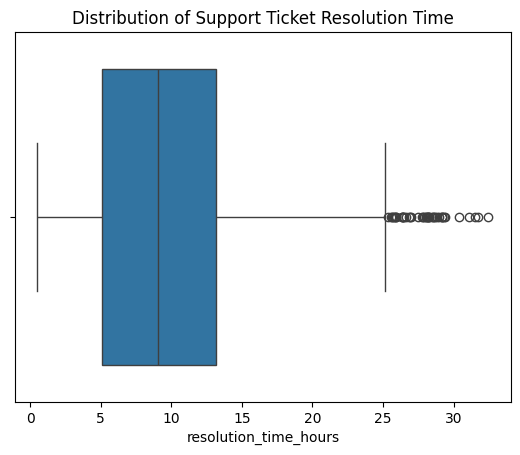

In [37]:
# Support usage distribution

plt.figure()
sns.boxplot(x=customer_support["resolution_time_hours"])
plt.title("Distribution of Support Ticket Resolution Time")
plt.show()

# the spread, median, and outliers
# The box plot confirms that support ticket resolution times are right-skewed. 
# The median resolution time lies well below the maximum
# with a relatively compact interquartile range, indicating that most tickets are resolved within a consistent time window. 
# A small number of high-duration outliers extend beyond the upper whisker
# - suggesting occasional complex or delayed cases rather than systemic service delays.

In [38]:
# Channel mix

customer_support["channel"].value_counts()

channel
email    298
chat     294
phone    287
-         39
Name: count, dtype: int64

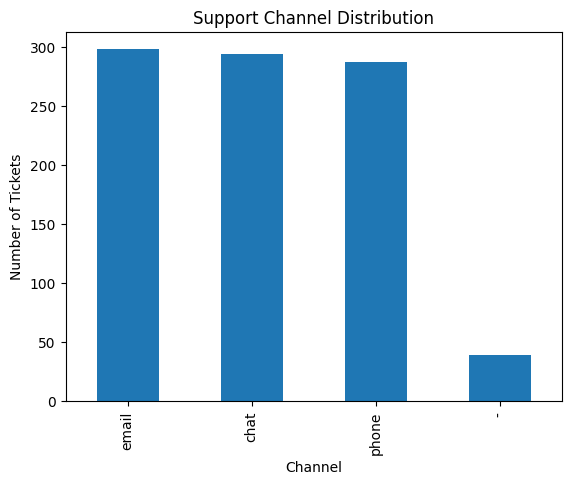

In [39]:
# Channel H to L

customer_support["channel"].value_counts().plot(kind="bar")
plt.title("Support Channel Distribution")
plt.ylabel("Number of Tickets")
plt.xlabel("Channel")
plt.show()

# data set shows that we have 3 categories under channel (email, chat, phone, -)
# the highest volume is email relatively equate to chat where teh diffference is qite small
# net is phone where is relatively smaller but not quite far from the alternatives
# the last on is "-" where the number is 39, it needs to be clarified where to add this or specifically tagg this as such.

### User Activity Overview:

explores user engagement patterns based on activity events,
including activity volume and engagement type distribution.


In [40]:
# Events per user

events_per_user = user_activity.groupby("user_id").size()
events_per_user.describe()

# this dataset answers the question; for each user how many activity events do we observe 
# we have a total of 246 of unique users encoded with atleast  activity event (regardless if: reading, watching, tracking or sharing)
# with 246 unique users with least 1 activity(min: 1) we have like 154 customers who have 0 recorded activity (total users; 400)
# mean: 1.8 meaning atleast each user have approx 1.8 activity event in comparison to total user of 400
# - meaning: we have a very light engagement
# - most users interact onece or almost twice, if not at all
# Stddev: 0.92 pretty low variation, this means most users behave similary (looks bad to me but lets not fall into conlusion nor assumtions)
# min unique useris 1 and max has 5 (25% of users did only 1 activity while 75% has 2 atleast)
# - the way it look engagement drops significantly and fast
# - most active users have only 5events quite low for a fitness app
# most users do not build on habits and can live on withoout this at all

count    246.000000
mean       1.808943
std        0.921446
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        5.000000
dtype: float64

User engagement is shallow across the platform.
Among users with recorded activity, 75% perform two or fewer actions, and even the most active users show limited engagement. Additionally, over one-third of customers have no recorded activity at all, suggesting early disengagement or incomplete tracking.

In [41]:
# Engagement type mix

user_activity["event_type"].value_counts()

# there are 4 catagories in this feature
# the highest count of clistered group is read articles with 125, a bit higher than watch video with 120
# the smallest values is share workout with 92

event_type
read_article     125
watch_video      120
track_workout    108
share_workout     92
Name: count, dtype: int64

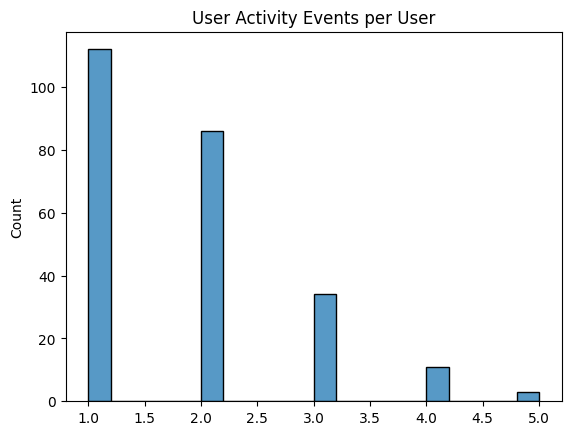

In [42]:
# Activity volume distribution

plt.figure()
sns.histplot(events_per_user, bins=20)
plt.title("User Activity Events per User")
plt.show()

# this graph shows the distribution of activity events per user
# each bar answers, how many users performed n number of of activities
# Most users interact with the platform once or twice and stop
# - heavy concentration on 1-2 bars this matches the 25% equate to 1 ehile 75% of users equivalet to 2's less events 
# - this clearly says week habit of usage and early dissengagement
# theres raoid drop after 2, meaning theres no strong core of highly egaged users here as fitness app
# we expect something like: daily logging, repeat workouts, frequent conten consumtion and tread and continious video watching
# the graph overall shows right skewed, the tail only goes 5 events max and there is no power user as well

User engagement is heavily concentrated at low activity levels. The majority of users perform only one to two actions, with very few progressing to higher engagement. This pattern suggests early drop-off and limited habit formation, which may contribute to elevated churn risk.

## EDA SUMMARY:

Fit.ly - Customer Churn & Engagement

This analysis explored customer accounts, user activity, and support interactions to understand engagement patterns and data limitations relevant to churn.

Only ~28.5% of customers have a recorded churn label, confirming that churn data is incomplete. As a result, findings focus on behavioral patterns rather than churn rate estimation or prediction.

User engagement is low and shallow. Out of 400 customers, only 246 show any recorded activity, and most active users perform one to two actions before disengaging. The maximum observed activity is just five events, indicating weak habit formation and early drop-off, with no evidence of highly engaged users. Engagement skews toward passive behaviors (reading articles and watching videos) rather than active participation such as workout tracking or sharing.

Customer support usage is widespread, with most users submitting two to three tickets on average. Resolution times are generally under 15 hours but show right-skew and variability, suggesting differing levels of issue complexity. Support channels are relatively balanced across email, chat, and phone.

Plan and pricing data show a customer base dominated by free and low-priced tiers, with prices following a right-skewed distribution. Low financial commitment combined with weak engagement may increase churn risk.

Overall, the data highlights early disengagement, limited usage depth, and incomplete churn labeling, setting clear boundaries for interpretation and informing the next stage of analysis.